# Plot attention weights

In [1]:
import pandas as pd
import numpy as np

import torch
from torch import nn

import matplotlib.pyplot as plt
import seaborn as sns

import pickle

In [2]:
import sys
sys.path.append("../Scripts/")

from models import model_v3
from util_funs import seq2index, cutseqs, highest_x, index2word_, word2index_
from util_att import evaluate, cal_attention


In [3]:
my_dict = pickle.load(open('../Embeddings/embeddings_12RM.pkl','rb'))  # 3-mers dict
middle_index = 499
length = 51  
radius = length // 2
num_task = 12
RMs = ['Am','Cm','Gm','Um','m1A','m5C','m5U','m6A','m6Am','m7G','Psi','AtoI']
RM_test = 'm6A'   # choose one modification to visualize
RM_test_index = RMs.index(RM_test)

In [4]:
# load data
y_true = pd.read_hdf('../Data/data_12RM.h5','test_out')
input_x = pd.read_hdf('../Data/data_12RM.h5','test_in_3_mers')
input_x_nucleo = pd.read_hdf('../Data/data_12RM.h5','test_in_nucleo')

In [9]:
y_true_pos = y_true.loc[y_true.iloc[:,RM_test_index]==1,:]   # only test positive data
input_x_pos = input_x.iloc[y_true_pos.index,middle_index-radius+1:middle_index+radius-1+1].sample()


input_x_pos.applymap(lambda x: index2word_(my_dict)[x])
y_true_pos_sample = y_true.iloc[input_x_pos.index,:]
input_x_nucleo_sample = input_x_nucleo.iloc[input_x_pos.index,middle_index-radius+1:middle_index+radius+2]
input_x_pos = torch.cuda.FloatTensor(input_x_pos.to_numpy())



# Initialize the model
model = model_v3(num_task,use_embedding=True).cuda()
model_path = '../Weights/MultiRM/trained_model_51seqs.pkl'
model.load_state_dict(torch.load(model_path))

# Input data into model and calculate attention weights
attention_weights_3mers, y_preds = evaluate(model,input_x_pos)
y_preds = y_preds[RM_test_index].cpu().detach().numpy()[0]
attention_weights = cal_attention(attention_weights_3mers)


In [10]:
attention_Df = pd.DataFrame(data=attention_weights[0,...],index=RMs,columns=input_x_nucleo_sample.values[0])

Text(0.5, 1.0, 'm6A prob 0.748962')

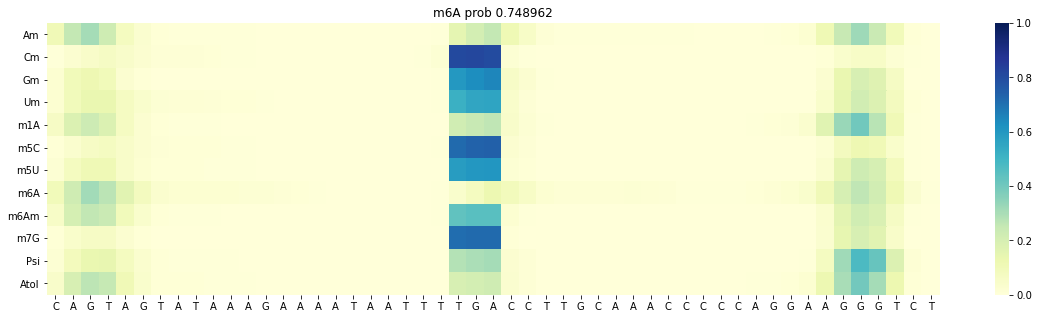

In [11]:
f, ax = plt.subplots(figsize=(20,5))
ax = sns.heatmap(attention_Df, vmin=0, vmax=1,cmap="YlGnBu")
ax.set_title('%s prob %f'%(RM_test,y_preds))
#f.savefig('./Figs/attention_map.png')